In [71]:
import pathlib
import sys

from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pyDOE2
from SALib.sample import morris
from SALib.analyze import morris as morris_analyze
from SALib.plotting import morris as morris_plot

In [2]:
def dist_generator(pars, distribution=None):
    """
    Generate SciPy distribution instance.

    Arguments:

    pars: NumPy 1-D array of two elements
        Parameters of the specified distribution of the uncertainty

    """
    if distribution is None:
        distribution = 'Uniform'
        print("Warning: Missing distribution type; set to uniform by default")

    switcher = {
        'Uniform': stats.uniform(loc=pars[0], scale=np.diff(pars)),
        'Normal': stats.norm(loc=pars[0], scale=pars[1]),
        'RandInt': stats.randint(low=pars[0], high=pars[1]),
    }
    return switcher.get(distribution, stats.norm())

In [3]:
# Settings
params = ['WWR', 'R-value', 'Infiltration']
values = [0.3, 11, 0.05]


p = len(params)
size = 100

r = 10
levels = 5

problem = {
    'num_vars': p,
    'names': params,
    'bounds': np.tile(np.array([1e-3, 1 - 1e-3]), (p, 1))
}

In [4]:
# Monte Carlo simulation with Latin Hypercube sampling
design_lhs = pyDOE2.lhs(
    p, size, criterion='maximin', iterations=20
)

In [5]:
# Morris method
design_morris = morris.sample(
    problem, N=r, num_levels=levels
)

In [6]:
lhs_sample = np.empty(design_lhs.shape)
morris_sample = np.empty(design_morris.shape)

for i, v in enumerate(values):
    d = dist_generator([v, v/30], 'Normal')
    lhs_sample[:, i] = d.ppf(design_lhs[:, i])
    morris_sample[:, i] = d.ppf(design_morris[:, i])

pd.DataFrame(lhs_sample, columns=params).to_csv('design_lhs.csv', index=False)
pd.DataFrame(morris_sample, columns=params).to_csv('design_morris.csv', index=False)

In [6]:
# Read sample
lhs_sample = pd.read_csv('design_lhs.csv').values
morris_sample = pd.read_csv('design_morris.csv').values

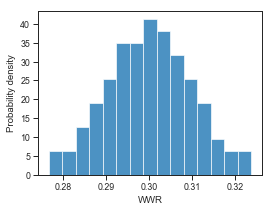

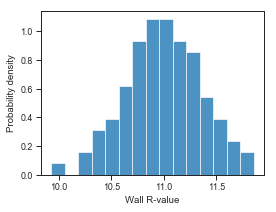

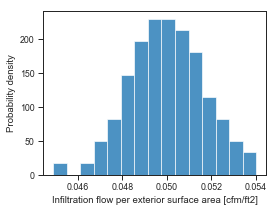

In [22]:
sns.set_style('ticks')
sns.set_context("paper", rc={"lines.linewidth": 2})

names = ['WWR', 'Wall R-value', 'Infiltration flow per exterior surface area [cfm/ft2]']

for i in range(len(names)):
    fig = plt.figure(figsize=(4, 3))
    ax = fig.add_subplot(111)
    ax.hist(
        lhs_sample[:, i], bins=15, alpha=0.8, density=True
    )
    ax.set_xlabel(names[i])
    ax.set_ylabel('Probability density')
    plt.savefig('histogram-{}.png'.format(params[i]), dpi=300)

#### LHS analysis

In [128]:
data_lhs = pd.read_csv('data_output_lhs.csv')
out_lhs = data_lhs.groupby('WWR').mean()['2004_shed_W_ft2'].values

In [129]:
out_lhs

array([0.36184256, 0.36175761, 0.3632766 , 0.36300682, 0.36306563,
       0.36384615, 0.36375673, 0.36430527, 0.36356269, 0.36482219,
       0.36493126, 0.36442514, 0.36514405, 0.36526894, 0.36552732,
       0.36497694, 0.36450369, 0.36517672, 0.36472527, 0.36529254,
       0.36613669, 0.36538287, 0.36586412, 0.3661592 , 0.36523759,
       0.36584885, 0.36559858, 0.366227  , 0.36572633, 0.36600978,
       0.36658299, 0.366039  , 0.36552901, 0.36651194, 0.3660755 ,
       0.36558731, 0.36650244, 0.36614436, 0.36623225, 0.36604771,
       0.36624707, 0.3666061 , 0.36609173, 0.36699952, 0.36578024,
       0.36653852, 0.3665021 , 0.36666823, 0.36662419, 0.36728645,
       0.36671153, 0.36667002, 0.36708558, 0.36761557, 0.36692122,
       0.36717023, 0.36766451, 0.36698944, 0.36729306, 0.36752071,
       0.36760179, 0.36741041, 0.36840095, 0.36732869, 0.3676447 ,
       0.36772899, 0.36741655, 0.36771645, 0.3675751 , 0.36723787,
       0.36717272, 0.36784923, 0.3677726 , 0.36810889, 0.36891

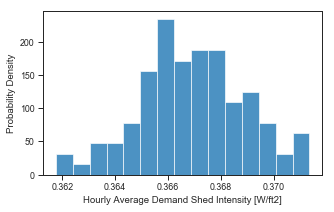

In [130]:
sns.set_style('ticks')
sns.set_context("paper", rc={"lines.linewidth": 2})
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)
ax.hist(
    out_lhs, bins=15, alpha=0.8,
    density=True
)
ax.set_xlabel('Hourly Average Demand Shed Intensity [W/ft2]')
ax.set_ylabel('Probability Density')
plt.savefig('histogram-mcs.png', dpi=300)

#### Morris method

In [29]:
design_morris = np.empty(morris_sample.shape)

for i, v in enumerate(values):
    d = dist_generator([v, v/30], 'Normal')
    design_morris[:, i] = d.cdf(morris_sample[:, i])

In [138]:
def plot_morris_cov(sa, name, outdir):
    """Plot result of sensitivity analysis using Morris method."""
    if np.isnan(sa['sigma']).any():
        # Remove sigma to trigger the use of 'mu_star_conf' in y axis by SALib
        sa_plot = sa.copy()
        sa_plot['sigma'] = None
        Y = sa['mu_star_conf']
    else:
        sa_plot = sa
        Y = sa['sigma']

    fig, ax = plt.subplots(figsize=(6, 5))
    morris_plot.covariance_plot(ax, sa_plot, {})

    # TEMPORARY
    ax.set_ylim(0, 0.001)
    ax.set_xlabel(r'$\mu^\star$ [W/ft2]')
    ax.set_ylabel(r'$\sigma$ [W/ft2]')

    x_offset = ax.get_xlim()[1] * 0.01
    y_offset = ax.get_ylim()[1] * 0.01
    for i in range(len(sa['names'])):
        plt.annotate(
            sa['names'][i],
            (sa['mu_star'][i] + x_offset, Y[i] + y_offset)
        )
    plt.savefig(outdir.joinpath('Morris_covplot-{}.png'.format(name)), dpi=300)
    plt.close()


def plot_morris_bar(sa, name, outdir):
    """Plot result of sensitivity analysis using Morris method."""
    # Use short variable name in plots
    sa_copy = sa.copy()

    fig, ax = plt.subplots(figsize=(6, 5))
    morris_plot.horizontal_bar_plot(ax, sa_copy, {})
    plt.savefig(outdir.joinpath('Morris_barplot-{}.png'.format(name)), dpi=300)
    plt.close()


def plot_morris_bar_sign(sa, name, outdir):
    """Plot result of sensitivity analysis using Morris method."""
    # Use short variable name in plots
    sa_copy = sa.copy()
    sa_copy['mu_star'] = sa_copy['mu']

    fig, ax = plt.subplots(figsize=(6, 5))
    morris_plot.horizontal_bar_plot(ax, sa_copy, {})
    ax.plot([0, 0], [ax.get_ylim()[0], ax.get_ylim()[1]], 'k--')
    ax.set_xlabel(r'$\mu$ [W/ft2]')
    plt.savefig(outdir.joinpath('Morris_barplot-sign-{}.png'.format(name)), dpi=300)
    plt.close()

In [131]:
data_morris = pd.read_csv('data_output_morris.csv')

In [132]:
data_morris['group_index'] = np.tile(np.asarray([list(range(1, design_morris.shape[0]+1))]), (792, 1)).flatten('F')

In [133]:
data_morris.head()

,Unnamed: 0,oat,bldg,2004_bldg,2004_shed_pct,2004_shed_W_ft2,WWR,R-value,Infiltration,group_index
0,2017-05-01 11:00:00,66.9200,121.249903,117.500408,0.030921,0.069917,0.269098,10.883407,0.05053,1
1,2017-05-01 12:00:00,68.8325,126.738710,119.701874,0.055477,0.131216,0.269098,10.883407,0.05053,1
2,2017-05-01 13:00:00,71.2175,125.968438,117.835987,0.064523,0.151646,0.269098,10.883407,0.05053,1
3,2017-05-01 14:00:00,71.9600,128.377888,118.388939,0.077801,0.186264,0.269098,10.883407,0.05053,1
4,2017-05-01 15:00:00,71.9600,132.888217,121.509968,0.085623,0.212170,0.269098,10.883407,0.05053,1


In [134]:
out_morris = data_morris.groupby('group_index').mean()['2004_shed_W_ft2'].values

In [135]:
out_morris

array([0.36132387, 0.36758607, 0.36717399, 0.36665475, 0.36125896,
       0.35969448, 0.36699451, 0.36678233, 0.36735401, 0.36605016,
       0.36596954, 0.37260588, 0.3728754 , 0.36617874, 0.36653387,
       0.36560558, 0.36105595, 0.36692263, 0.36850284, 0.36861327,
       0.36870965, 0.36889468, 0.36208644, 0.36089896, 0.35948862,
       0.36132387, 0.36121363, 0.36717399, 0.35993266, 0.35969448,
       0.36125896, 0.36754699, 0.36747819, 0.36742066, 0.36616185,
       0.37284831, 0.36870965, 0.3670141 , 0.36676563, 0.36089896])

In [136]:
sa = morris_analyze.analyze(
    problem, X=design_morris, Y=out_morris, num_levels=levels
)

In [137]:
sa

{'names': ['WWR', 'R-value', 'Infiltration'],
 'mu': array([ 0.01029947, -0.00215002,  0.00015577]),
 'mu_star': array([0.01029947, 0.00215002, 0.00032158]),
 'sigma': array([0.00075094, 0.00063203, 0.00035096]),
 'mu_star_conf': [0.00044743424456883055,
  0.000372550182592624,
  0.00011014064160394386]}

In [139]:
plot_morris_cov(sa, 'test', pathlib.Path.cwd())
plot_morris_bar(sa, 'test', pathlib.Path.cwd())

In [140]:
plot_morris_bar_sign(sa, 'test', pathlib.Path.cwd())